# Use the model to make predictions on the un-seen training set then verify the labels.

The initial small model was trained on a subset of the training data. 

Cleaning of the training set can proceed in the same manner as the cleaning of the validation set - either by picking 1000 samples from each class to manually verify, or by sorting the samples by highest loss and cleaning out the top 20% of errors. 

Manually checking 1000 samples takes about 4-5 hours. 

# Clips will be listened to and labelled with the following confidence categories:

Confidence scores:
- 0 UNCHECKED means it hasn't been verified
- 1 DISCARD is something to throw out, 
- 2 UNSURE is not sure
- 3 VERIFIED means the label is definitely correct
- 4 FOCAL means the present label is correct and the target species vocalization is prominent
- 5 Label needs changing from absent to present 
- 6 Label needs changing from present to absent

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import sys
BASE_PATH = Path.cwd().parent.parent
data_path = BASE_PATH / "data"
model_save_path = BASE_PATH / "models"
sys.path.append(str(BASE_PATH))
import opensoundscape as opso
from opensoundscape import Audio, Spectrogram
from opensoundscape.preprocess.utils import show_tensor
from src.utils import verify_samples, remove_short_clips
from matplotlib import pyplot as plt

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [752]:
%load_ext autoreload
%autoreload 2

random_seed = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Load the training set
train_df = pd.read_pickle(data_path / "interim" / "train_set" / "train_set.pkl")
train_df = remove_short_clips(train_df)
train_ds = train_df[["target_present"]]
train_df.target_present.value_counts()

7 short clips dropped from the dataframe:


target_present
0.0    35377
1.0     2296
Name: count, dtype: int64

# Load a model and make predictions on the unseen training set. 

#### * Skip this section if verification has already begun.

In [4]:
model = opso.cnn.load_model(model_save_path / "initial_small.model")
predictions = model.predict(train_ds, batch_size=64, activation_layer="sigmoid")
# predictions.rename(columns={"target_present": "predicted"}, inplace=True)

  0%|          | 0/589 [00:00<?, ?it/s]

# If you got the following error during this stage
"__Audio object is shorter than requested duration__"


Run the notebook again and the error samples will be automatically cleaned on the next run. 

In [5]:
train_df['predicted'] = predictions['target_present']

In [6]:
def calculate_loss(df):
    return abs(df["target_present"] - df["predicted"])

train_df["loss"] = calculate_loss(train_df)


# add a column to the dataframe to store the confidence of the label, if it doesn't alredy exist
if 'confidence_cat' not in train_df.columns:
    train_df['confidence_cat'] = 0

# * If cleaning has already begun, load the cleaned data here instead
This will load any previously entered confidence category work. 

In [3]:
if Path.exists(data_path / "interim" / "train_set" / "train_set_verified.pkl"):
    train_df_verified = pd.read_pickle(data_path / "interim" / "train_set" / "train_set_verified.pkl")
else:
    train_df_verified = train_df

In [398]:
# Choose a sample of the training data labelled as 'present' for verification. 
present_1200 = train_df_verified.loc[train_df_verified.target_present == 1.0].sample(1200, random_state=random_seed)

# Verify 1200 samples from the present class. 

To cycle through the samples, hit ctrl+enter to execute the current code cell and keep it focussed. 

In [1450]:
train_df_verified.loc[present_1200.index] = verify_samples(present_1200, loss_sorted=True)

No unverified clips within chosen target class.


In [1453]:
present_1200.confidence_cat.value_counts()

confidence_cat
3    828
2    196
6    139
4     36
1      1
Name: count, dtype: int64

We were aiming for 1000 verified present samples, but after cleaning 1200 present samples we still only end up with 862 verified samples. We can verify another 200 samples to make the count up to 1000. Let's pick from the samples with the lowest loss since these are likely to be good clear examples of the target sound which should help with training. 

In [1474]:
df = train_df_verified
present_200 = df.loc[df.confidence_cat == 0.0].loc[df.target_present == 1.0].sort_values('loss').iloc[:200]

In [1678]:
present_200 = verify_samples(present_200)

No unverified clips within chosen target class.


In [1680]:
present_200.confidence_cat.value_counts()

confidence_cat
3    190
4      6
2      4
Name: count, dtype: int64

In [3331]:
def undo_label(df, prob):
    # # Re-label mistaken sample here
    df.loc[df.predicted == prob, 'confidence_cat'] = 0

In [ ]:
# In case a mistake entry is made, undo here by copying probability into current_prob
current_prob = 1.0
df = train_df_verified
last_3 = df.loc[df.predicted >= current_prob].loc[df.target_present == 0].sort_values('predicted').predicted.values[:3]

probs = last_3
for prob in last_3:
       undo_label(train_df_verified, prob)

# Verify the absent class
The absent class is much larger than the present class, so we'll use a different strategy to clean the samples:

- Go through the samples with the label __target_present = 0__ which have the the highest loss and re-label those which actually contain the target class. This was done for all the samples with a predicted probability above 0.80.

- Take a sample of 1000 absent and 1000 present samples and verify each of these. 

- We can take advantage of the small model's predictions and our verification work to add more confusing samples into the training data: take 200 samples from the top end of the loss sorted training set, which were also confirmed as belonging to the absent class, and add these to the absent class of the training data. 

- This will give us a fully checked training set with equal numbers of samples from each class. The training set will include examples in the absent class which were most confusing in the previous run. 

- Additionally we'll have gone through the top section of samples in the training set which are a mixture of mis-labels and easily confused vocalizations. This would be a good time to start noticing any other species which have similar calls to the target species. Try downloading them and uploading their recordings at https://birdnet.cornell.edu/api/ then verifying the ID [here](https://academy.allaboutbirds.org/peterson-field-guide-to-bird-sounds/?speciesCode=olsfly&species=Olive-sided%20Flycatcher%20-%20Contopus%20cooperi). 

target = 0.0, prediction = 0.7999122738838196 loss = 0.7999122738838196


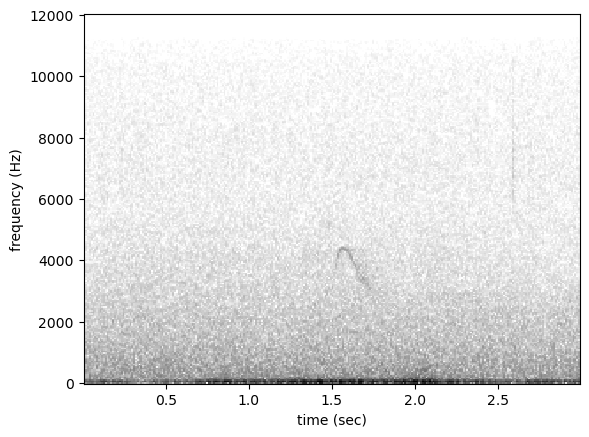

added confidence tag 3 to the dataframe.
verification counts for target_present = 0.0
confidence_cat
0    33571
3     1421
5      231
2      152
1        2
Name: count, dtype: int64


/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:386: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[clip_idx, "confidence_cat"] = int(user_confidence)


In [3606]:
train_df_verified = verify_samples(train_df_verified, ground_truth=0.0, loss_sorted=True)

# Category totals for target present labels in the training set
There are still some labelled 0 since we took a random sample to verify. 

<Axes: xlabel='confidence_cat'>

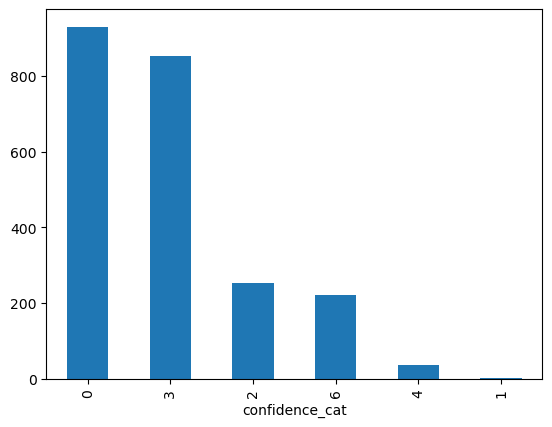

In [3610]:
counts = train_df_verified.loc[train_df_verified.target_present==1.0].confidence_cat.value_counts()
counts.plot(kind='bar')


# Category totals for the absent labels in the training set

In [3612]:
train_df_verified.loc[train_df_verified.target_present==0.0].confidence_cat.value_counts()


confidence_cat
0    33571
3     1421
5      231
2      152
1        2
Name: count, dtype: int64

After verifying the present samples in the training set

In [3617]:
# Build a balanced training set.

n_samples_per_class = 1000
# Choose all of the focal present samples
present_focal = present_1200.loc[present_1200.target_present==1.0].loc[present_1200.confidence_cat==4]

# Add all of the 200 lowest error samples
present_focal = pd.concat([present_focal, present_200.loc[(present_200.confidence_cat == 3.0) | (present_200.confidence_cat == 4.0)]])

# Choose a random sample of the remaining present_1200 samples to make it up to 1000
present = present_1200.loc[present_1200.target_present==1.0].loc[present_1200.confidence_cat==3]
present_1000 = pd.concat([present_focal, present.sample(n=n_samples_per_class-len(present_focal))])
print(len(present_1000))


1000


That has given us exactly 1000 verified present samples. 

In [3618]:

# Choose a random sample of 1200 absent samples to verify - knowing that we'll want to end up with 1000 and some will be mis-labelled.
absent = train_df_verified.loc[train_df_verified.target_present==0.0].sample(n=n_samples_per_class + 200)

In [1177]:
absent = verify_samples(absent, ground_truth=0.0, loss_sorted=True)

No unverified clips within chosen target class.


To handle the following error:
``` python3
ValueError: Audio data must be between -1 and 1 when normalize=False.
```
Remove the sample from the database: paste the path of the file into the cell below and replace PosixPath with Path.

In [1178]:
def remove_sample_from_df(df, path):
    df.drop(path, inplace=True)
# remove_sample_from_df(absent, ((Path('../../data/raw/recordings/OSFL/recording-100184.mp3'), 7.5, 10.5)))

# Reinforce the training set with the most confusing examples

These are the examples which are most likely to lead to false positives or false negatives during production. 
We can hand pick the most confusing samples by sampling from the verified samples with the highest loss. This will have the effect of including more examples in the training data which are likely to be identified incorectly - so the model can learn to better differentiate between these. 

In [1184]:
most_confusing_absences = train_df_verified.loc[train_df_verified.target_present==0.0].loc[train_df_verified.loss > 0.95].loc[train_df_verified.confidence_cat == 3.0]

In [1187]:
# absent = absent.loc[absent.confidence_cat==3].sample(n=n_samples_per_class, random_state=42)

absent_1000 = pd.concat([most_confusing_absences.sample(200), absent.sample(n=n_samples_per_class-200)])
balanced_train_df = pd.concat([present_1000, absent_1000])

balanced_train_df.target_present.value_counts()


target_present
1.0    1000
0.0    1000
Name: count, dtype: int64

# Save the verification work to disk

In [1188]:
train_df_verified.to_pickle(data_path / "interim" / "train_set" / "train_set_verified.pkl")

In [1189]:
balanced_train_df.to_pickle(data_path / "interim" / "train_set" / "balanced_train_set_verified.pkl")

In [1190]:
train_df_verified.target_present.value_counts()

target_present
0.0    35377
1.0     2296
Name: count, dtype: int64

# Concluding notes
We started out with a data set which relied entirely on human labels from wildtrax. Some of these contained errors, so we trained an initial model using this noisy data, and used it as an aid for cleaning the training set in the following way:

1. A set of 1000 verified present samples and 1000 verified absent samples were saved as __balanced_valid_set_verified__. The absent samples contain a sample of the 200 samples with highest loss when run through the initial model, in order to increase the rate of examples which sound like the target species, but which are in fact not the target species.

2. A larger set of present and absent data is available, and the top 20% of the errors in the absent data has been verified so that those clips most likely to contain mis-lables have been checked. This dataset is saved as __train_set_verified__
